In [2]:
import sys
import time
import dimod
import minorminer
import numpy as np
import pandas as pd
from tqdm import tqdm
sys.path.append('../../lib/')
import matplotlib.pyplot as plt 
import matplotlib.colors as mpl_color
import networkx as nx, dwave_networkx as dnx
from frustration_graph import bqm_frustration

In [3]:
width = 5.949973986 # in inches
ratio = (np.sqrt(5.0) - 1.0) / 2.0

Frustrated Ising Graph

In [4]:
L = 20
Lattice_Size = (L, L)
G = nx.grid_graph(dim=Lattice_Size, periodic=False)
G1 = nx.Graph()

In [5]:
for x in range(L-1):
    for y in range(L-1):
        # diagonals on right
        G1.add_edge((x,y), (x+1, y+1))
        G1.add_edge((x + 1,y), (x, y+1))

In [6]:
pos = {}
for node in G.nodes:
    x, y = node
    pos[node] = (y, -x)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


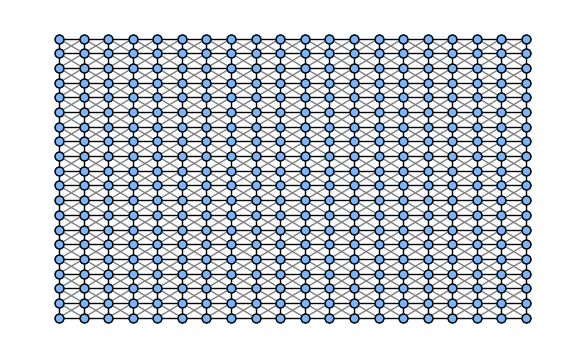

In [7]:
fig = plt.figure(figsize=(width, width * ratio))
fig.set_tight_layout({'pad': 0})

nx.draw_networkx(G1, pos=pos, node_size=40, with_labels=False, edge_color='gray')
nx.draw_networkx_nodes(G, pos=pos, node_color=[123/255, 180/255, 248/255], edgecolors='k', node_size=40)
nx.draw_networkx_edges(G, pos=pos)
plt.axis('off')
plt.tight_layout()
#plt.savefig("../../Images/Ising_Frustrated/F_Ising_Model.pdf")

Embedding on Pegasus Graph

In [18]:
L = 3
ratio = 0.6
bqm = bqm_frustration(L, ratio, 0)
G = bqm.to_networkx_graph()
P = dnx.pegasus_graph(2)

C:\Users\cosmi\AppData\Local\Temp\ipykernel_19152\1127123807.py:4: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  G = bqm.to_networkx_graph()


In [19]:
pos = {}
for node in G.nodes:
    split = node.split('-')
    x, y = int(split[0]), int(split[1])
    pos[node] = (y, -x)

In [20]:
emb = minorminer.find_embedding(G, P)

In [21]:
def color(i, n):
    r, g, b = mpl_color.hsv_to_rgb((i/n, .25 + (i%4)/4, 1))
    return r, g, b, 1.

def double_plot(S, T, emb, save, params):
    n = len(S)
    colors = {v: color(i, n) for i, v in enumerate(S)}

    node_colors = list(colors[v] for v in S)

    if params[0].get('pos') is None:
        params[0]['pos'] = nx.kamada_kawai_layout(S)
      
    
    fig = plt.figure(**params[2])
    axes = fig.subplots(nrows=1, ncols=2)

    nx.draw(S,
            node_color = node_colors,
            ax = axes[0],
            **params[0])

    dnx.draw_pegasus_embedding(T, emb, S,
                               crosses = False, 
                               chain_color = colors,
                               ax = axes[1],
                               **params[1])


    fig.tight_layout()
    if save:
        fig.savefig("../../Images/Ising_Frustrated/FIsing_embedding.pdf")

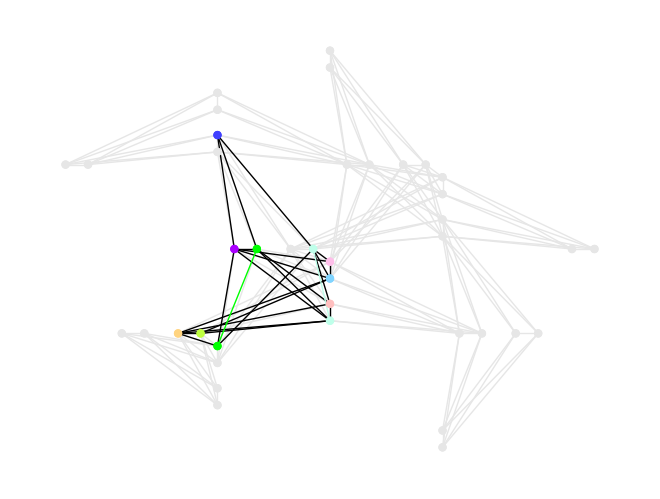

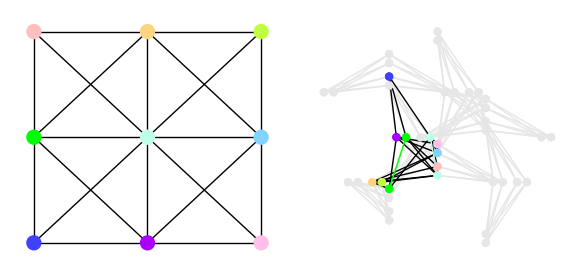

In [22]:
save = 0
double_plot(G, P, emb, save, [{'node_size': 100, 'pos': pos, 'width': 1, 
                 'edge_color': 'k'}, {'node_size': 25, 'width': 1}, {"figsize":(width, 0.8* width * ratio)}])

## Embedding Study for different dimensions

In [12]:
def embeddings(lens):
    ratio = 0.6
    
    N_Nodes = []
    N_Chains = []
    Time = []
    
    P = dnx.pegasus_graph(16)
    
    for L in tqdm(lens):
        bqm = bqm_frustration(L, ratio, 0)
        G = dimod.to_networkx_graph(bqm)
        
        time_in = time.time()
        emb = minorminer.find_embedding(G, P, threads=12)
        time_fin = time.time()
        
        Time.append(time_fin - time_in)

        if not emb:
            N_Nodes.append("Not Find")
            N_Chains.append("Not Find")
        else:
            nodes, chains = 0, 0
            for qubits in emb.values():
                nodes += len(qubits)
                if len(qubits) > 1:
                    chains += 1

            nodes, chains
            N_Nodes.append(nodes)
            N_Chains.append(chains)
    
    df = pd.DataFrame({"L": list(lens), "LxL": np.power(lens, 2), 
                       "Qubits": N_Nodes, "N Chains": N_Chains, "Time": Time})
            
            
    return df

In [13]:
df = embeddings(range(10, 70, 10))
df

100%|██████████| 6/6 [40:37<00:00, 406.27s/it]


,L,LxL,Qubits,N Chains,Time
0,10,100,199,71,0.456144
1,20,400,934,300,4.523891
2,30,900,2175,727,15.694900
3,40,1600,4062,1322,405.912035
4,50,2500,Not Find,Not Find,1005.842447
5,60,3600,Not Find,Not Find,1004.839055


In [18]:
#print(df.style.hide(axis="index").to_latex())

\begin{tabular}{rrllr}
L & LxL & Qubits & N Chains & Time \\
10 & 100 & 199 & 71 & 0.456144 \\
20 & 400 & 934 & 300 & 4.523891 \\
30 & 900 & 2175 & 727 & 15.694900 \\
40 & 1600 & 4062 & 1322 & 405.912035 \\
50 & 2500 & Not Find & Not Find & 1005.842447 \\
60 & 3600 & Not Find & Not Find & 1004.839055 \\
\end{tabular}

